<img src="images/slide.png" alt="venmo" width="800">

In [1]:
import networkx as nx
print(nx.__version__)

import pandas as pd
import collections

import matplotlib.pyplot as plt

from utils.pos import pos

from IPython.display import Image

2.5.1


In [2]:
# Create an empty graph (no nodes and no edges)
G = nx.Graph()

> In NetworkX, nodes can be any hashable object e.g., a text string, an image, an XML object, another Graph, a customized node object, etc.


([docs](https://networkx.github.io/documentation/stable/tutorial.html#creating-a-graph))


#### Populate the Graph

We can pass a list of tuples (node1, node2) and networkx will interpert each tuple as <br>
having an edge between (or from, in directed graphs) node1 and node2.

In [3]:
G.add_edges_from([('Leonard', 'Jon'),
                 ('Hunter', 'Brian'),
                 ('Ericka', 'Monica')])

We just created our first network - that was easy! <br>
Let's see what it looks like

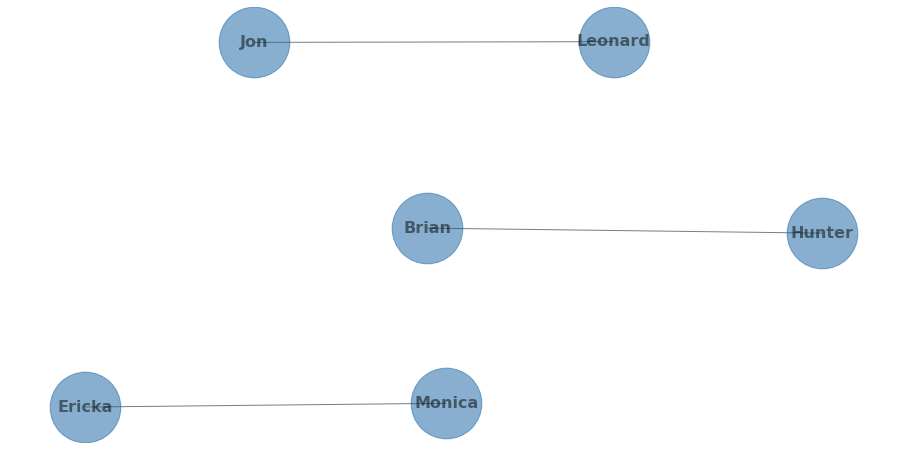

In [4]:
plt.figure(figsize=(16,8), frameon=False)

limits = plt.axis('off')

nx.draw(G,                              # our graph
        node_size=5000,                 # just so it's easier to read
        font_size=16,
        font_weight='bold',
        node_color='#1261A0', alpha=.5,
        with_labels=True,
        pos=nx.spring_layout(G, k=.8)) # spread the nodes for legibility

## We created our first network...
## but it is not super exciting :(

Here's what we'll do then:

1. Create a large network from a bigger data set<br>
2. We'll break the large graph to smaller independent sub-graphs (connected-components)<br>
3. We'll zoom in on one _connected-component_ <br>
4. We'll discover _communities_ withing that connected component.<br>
5. Finally we'll zoom in to interesting individuals<br>

In other words:

Large Graph<br>
⬇️<br>
one subgraph<br>
⬇️<br>
communities<br>
⬇️<br>
individuals

## Load Bigger Data

(Note: obfuscated data)

We'll use Pandas (<3), other raw data formats NetworkX handles well include Pickle, JSON. [(docs)](https://networkx.github.io/documentation/stable/reference/readwrite/index.html)

In [5]:
pmts_df = pd.read_csv('data/p2p_payments.csv', usecols=['sender_id', 'receiver_id'])

In [6]:
print(pmts_df.shape)
pmts_df.head()

(637561, 2)


,sender_id,receiver_id
0,44,8112587
1,191,437
2,6219,27764111
3,7435,6648928
4,11823,1276277


In [7]:

G = nx.from_pandas_edgelist(pmts_df,                       # DataFrame with raw data
                            source='sender_id',            # From.. (some dataframes have more than 2 columns...)
                            target='receiver_id',          # To..
                            create_using=nx.DiGraph())     # <== This is a Directed Graph (technically, a MultiDiGraph, but we'll get to that later)


# Let's see what we're working with
# (you can also use nx.info(G))

print(nx.number_of_nodes(G), 'nodes (= people)')
print(nx.number_of_edges(G), 'edges (= $ transfers)')
print(nx.number_of_isolates(G), 'isolates - nodes with no neighbours')

709625 nodes (= people)
637560 edges (= $ transfers)
0 isolates - nodes with no neighbours


### Visualizing the Large Network

➡️(UNHIDE)

<!-- <img src="images/large_graph.png" alt="drawing", width="800"> -->

<img src="images/large_graph.png" alt="large graph" width="800">

This is not very helpful.. what can we do?
+ We can visualize and analyse the large network with NetworkX and/or external tools
+ We can zoom in on one 'sub group' of this large network and see if we can find something interesting there.

We'll go with the second option:
+ Easier to gain intuitive understanding of some of the concepts as it’s easier to see. 
+ Larger networks are less intuitive and more resource heavy.

The way to look at a 'sub group' is with:

## Connected Components

A connected component is a subset of the nodes of the graph such that:
+ There is a _path_ between any two nodes of the subset.
+ No other node in the graph has a path to any of the nodes in the subset.

<img src="images/cc.png" alt="venmo" width="700">

However, if we cut just one edge out:

<img src="images/cc2.png" alt="venmo" width="700">

Back to our data...

In [8]:
WCC = nx.weakly_connected_components(G)  # returns a generator

WCC = list(WCC)

# To explore what CCs were created:
lens = map(len, WCC)
d = collections.Counter(lens)

print(f'There are {len(WCC)} Connected Components and the largest connected component is {max(d.keys())} members strong!')

There are 157987 Connected Components and the largest connected component is 18630 members strong!


In [9]:
print('Top 5 largest connected components:')
sorted(d.items(), key=lambda pair: pair[0], reverse=True)[:5]

Top 5 largest connected components:


[(18630, 1), (1850, 1), (1573, 1), (1215, 1), (806, 1)]

In [10]:
# We'll zoom in on one CC which I conveniently cherry picked beforehand 

cherry_picked = [88747525, 180629853, 25648751, 178226065, 172578712, 200345769, 78935231, 148311246, 131678335, 157137118, 87972129, 
                 93085738, 139862068, 109200971, 89357141, 152546927, 39964577, 164939951, 156165568, 136860636, 70296805, 50857457, 
                 132641831, 82053696, 129704264, 162538841, 135319667, 143529671, 117152739, 170878296, 68738163, 63721855, 144630663, 
                 133914532, 56716492, 113089048, 34949035, 171734174, 54646997, 135317744]

We'll now create a **Subgraph**<br>
A subgraph is essentially a 'subset' of the original (Supergraph) for given nodes.<br>
If we pass a list of nodes, networkx knows to take the relevant edges and information (direction, weights, attributes...) from the **Supergraph**.

In [11]:
Gsub = G.subgraph(nodes=cherry_picked)

print(nx.number_of_nodes(Gsub), 'nodes')
print(nx.number_of_edges(Gsub), 'edges')

40 nodes
78 edges


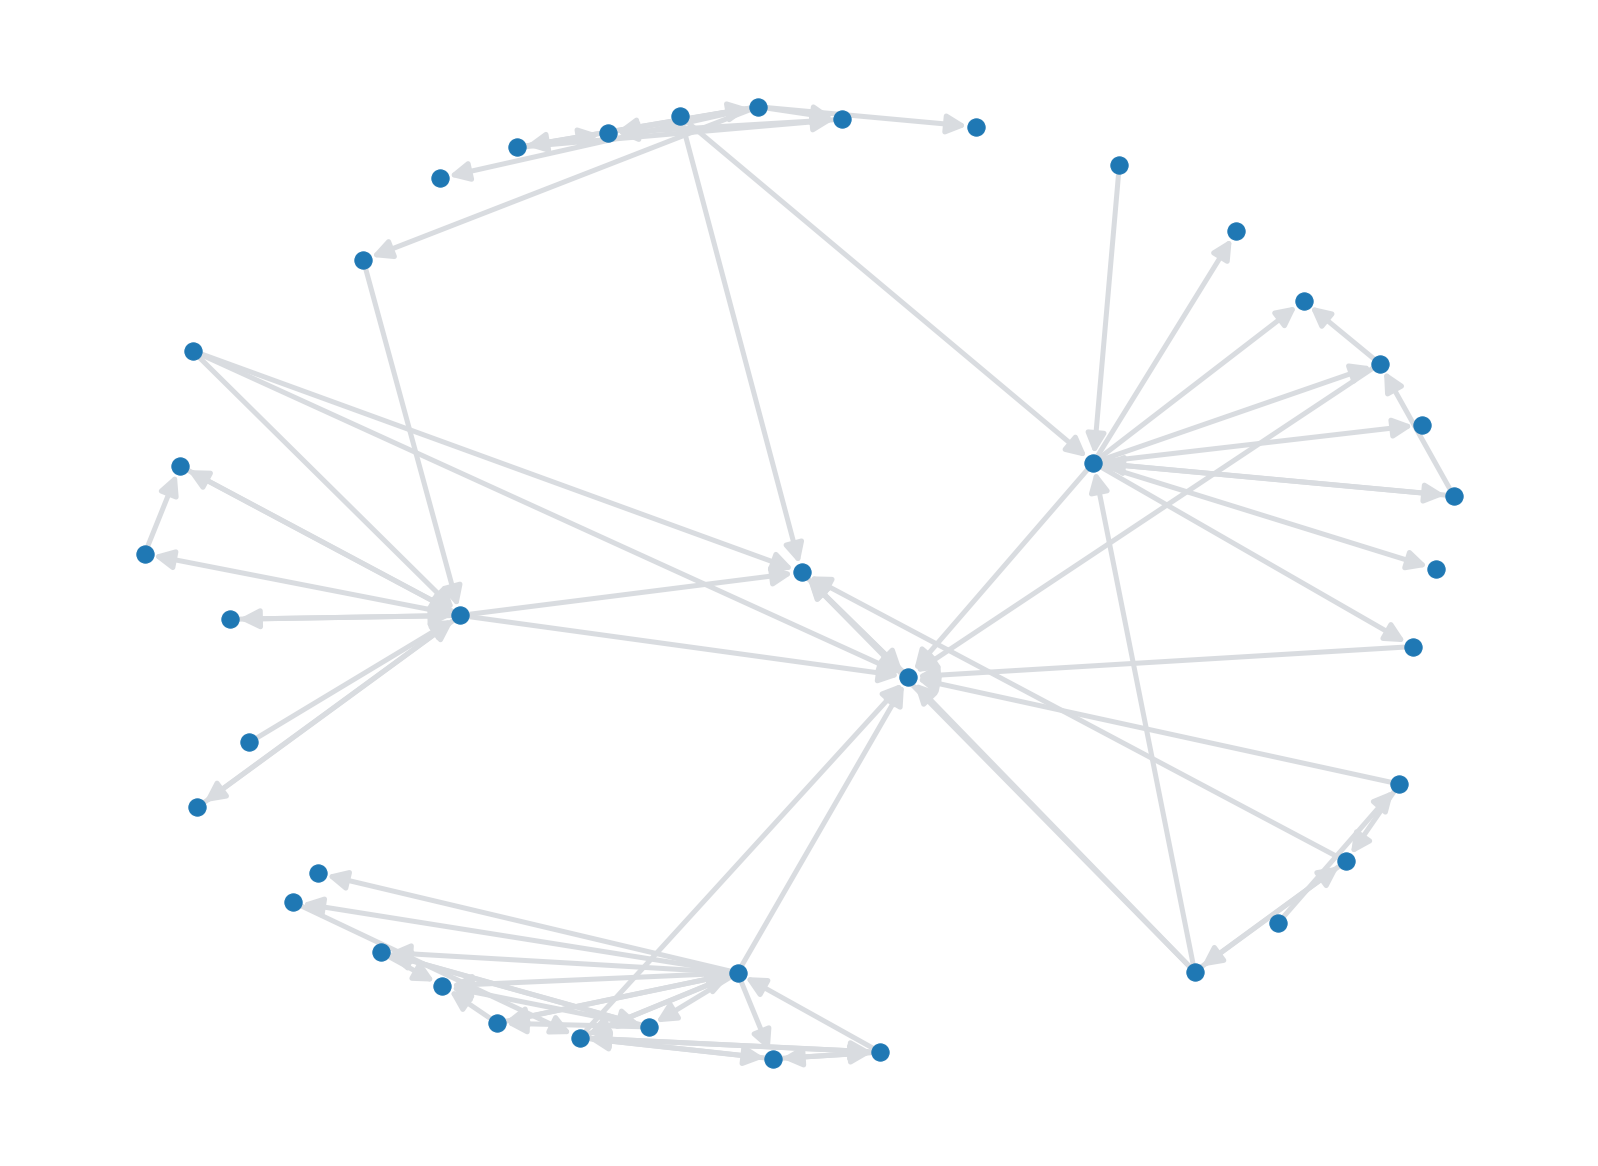

In [12]:
# let's see what that subgraph looks like!

plt.figure(figsize=(22,16))


nx.draw(Gsub, 
        edge_color='#d9dce0',
        width=5,
        pos=pos,         # positions of the nodes, preconfigured earlier 
        arrowsize=40)  

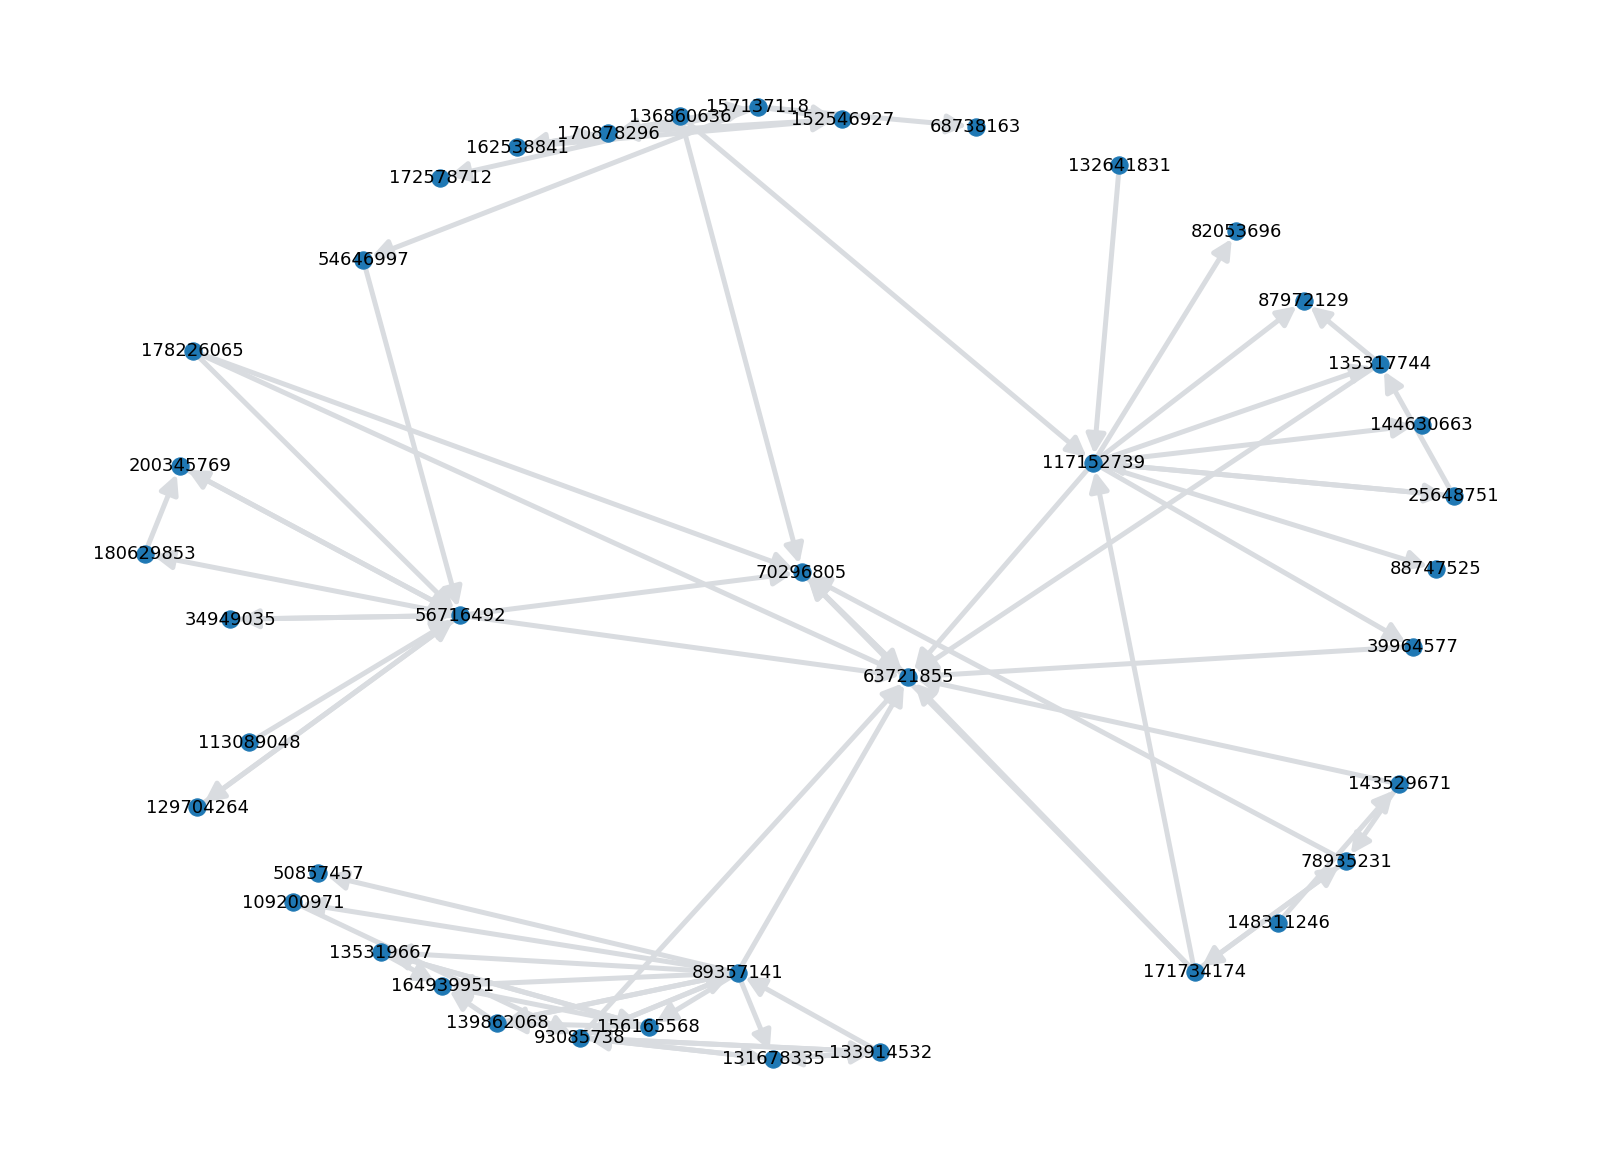

In [13]:
# Add user ids

plt.figure(figsize=(22,16))


nx.draw(Gsub, 
        edge_color='#d9dce0',
        width=5,
        font_size=18, 
        pos=pos, 
        arrowsize=40,
        with_labels=True)  # <====

User IDs are very impersonal.. let's add some names.

### Add Node Attributes

In [14]:
node_atts_df = pd.read_csv('data/node_attributes.csv', index_col='userid', usecols=['userid', 'first_name', 'gender'])

node_atts_df.head()

,first_name,gender
userid,,
88747525,Amy,Female
180629853,Hermes,Male
25648751,Hubert,Male
178226065,Zoidberg,Male
172578712,Nibbler,Male


In [15]:
# Turn that to a dict, gotta <3 pandas
node_atts_d = node_atts_df.to_dict(orient='index')


# and apply - a little long but it works!
nx.classes.function.set_node_attributes(Gsub, node_atts_d)

In [16]:
# let's see that attributes were set

Gsub.nodes[88747525]

{'first_name': 'Amy', 'gender': 'Female'}

In [17]:
# we can access the node attributes by:
# Gsub.nodes.data()

# or a specific attribute by a key
nx.get_node_attributes(Gsub, 'first_name')

{88747525: 'Amy',
 63721855: 'Leela',
 144630663: 'Roberto',
 178226065: 'Zoidberg',
 172578712: 'Nibbler',
 113089048: 'Scruffy',
 171734174: 'Smitty',
 87972129: 'Calculon',
 39964577: 'Cubert',
 133914532: 'RobotDevil',
 132641831: 'GelatinousBlob',
 200345769: 'Zapp',
 93085738: 'Crushinator',
 34949035: 'BarbadosSlim',
 164939951: 'Flexo',
 139862068: 'Clamps',
 78935231: 'Kif',
 156165568: 'AlGore',
 82053696: 'Hypnotoad',
 143529671: 'Nixon',
 129704264: 'Lrrr',
 109200971: 'LeBarbara',
 56716492: 'Bender',
 148311246: 'Mom',
 89357141: 'Donbot',
 54646997: 'Wenstrom',
 170878296: 'Panucci',
 162538841: 'Michelle',
 136860636: 'Gypsy-bot',
 180629853: 'Hermes',
 157137118: 'Boxy',
 117152739: 'Zoidberg',
 70296805: 'Fry',
 25648751: 'Hubert',
 152546927: 'Elzar',
 50857457: 'Hedonismbot',
 135317744: 'Wong',
 135319667: 'Morbo',
 68738163: 'Preacherbot',
 131678335: 'Agnew'}

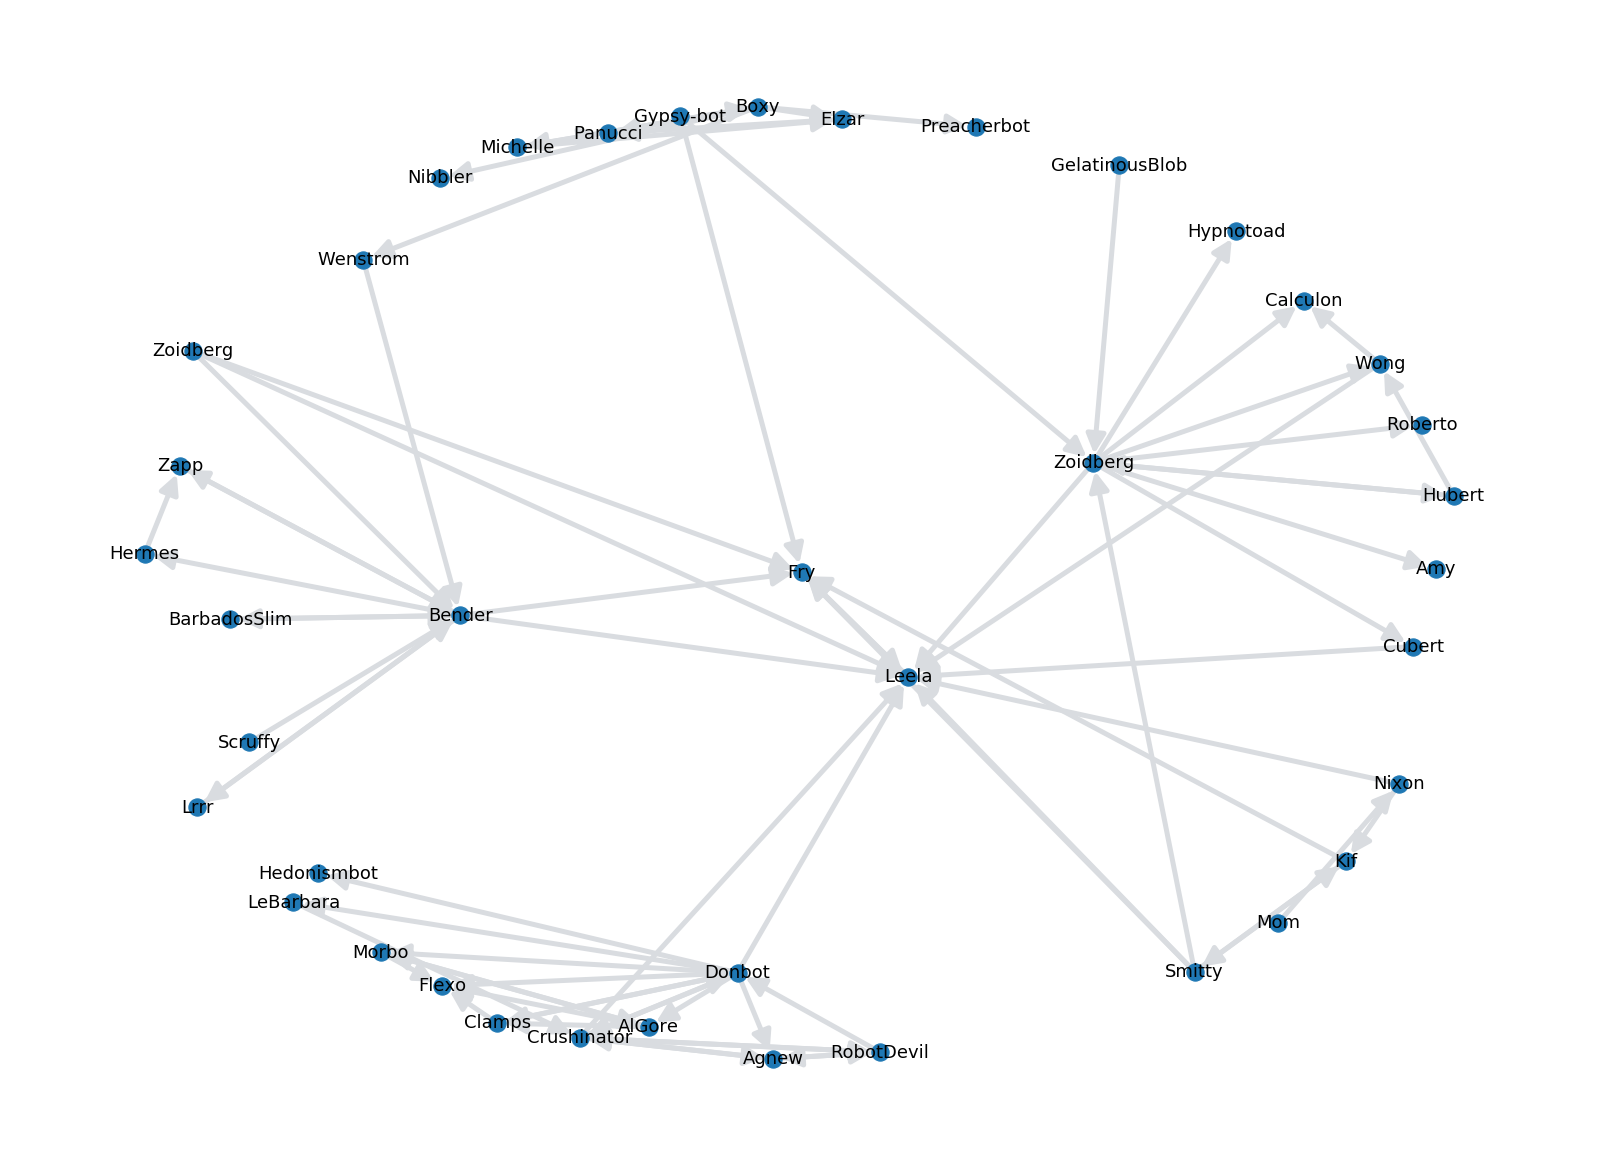

In [18]:
plt.figure(figsize=(22,16))

node_lables = nx.get_node_attributes(Gsub, 'first_name')  # <==== (graph, attribute)

nx.draw(Gsub, 
        edge_color='#d9dce0',
        width=5,
        font_size=18, 
        pos=pos, 
        arrowsize=40,
        labels=node_lables, # <====
        with_labels=True)  

Similarly, there are also _edge attributes_, for example the "weight" of the edge.

### Checkpoint

✅Large Graph (~700k nodes)<br> 

✅Connected Components (~158k CC)

✅one subgraph (~40 nodes)<br>

Next: <br>

+ communities<br>

+ individuals of interest

## Detecting Communities

Very high level: 

Communities tend to have dense connections between the nodes within a community, but sparse connections between nodes in different communities.

(you have your group of friends, other people have their own; you are not part of theirs and they are not a part of yours).

Different from connected components, where there are no paths connecting one component to another.

<img src="images/communities.png" alt="venmo" width="700">

In [19]:
import community

# Not bundled in NetworkX.
# Uses Louvain algorithm. 
# pip install python-louvain

# Alternatively: nx.algorithms.community.centrality.girvan_newman(Gsub), uses Girvan-Newman algorithm

communities = community.best_partition(Gsub.to_undirected(), resolution=.75)  # cheating a little bit here too, by passing an undirected graph..

print(f"{len(set(communities.values()))} distinct communities were detected!")

5 distinct communities were detected!


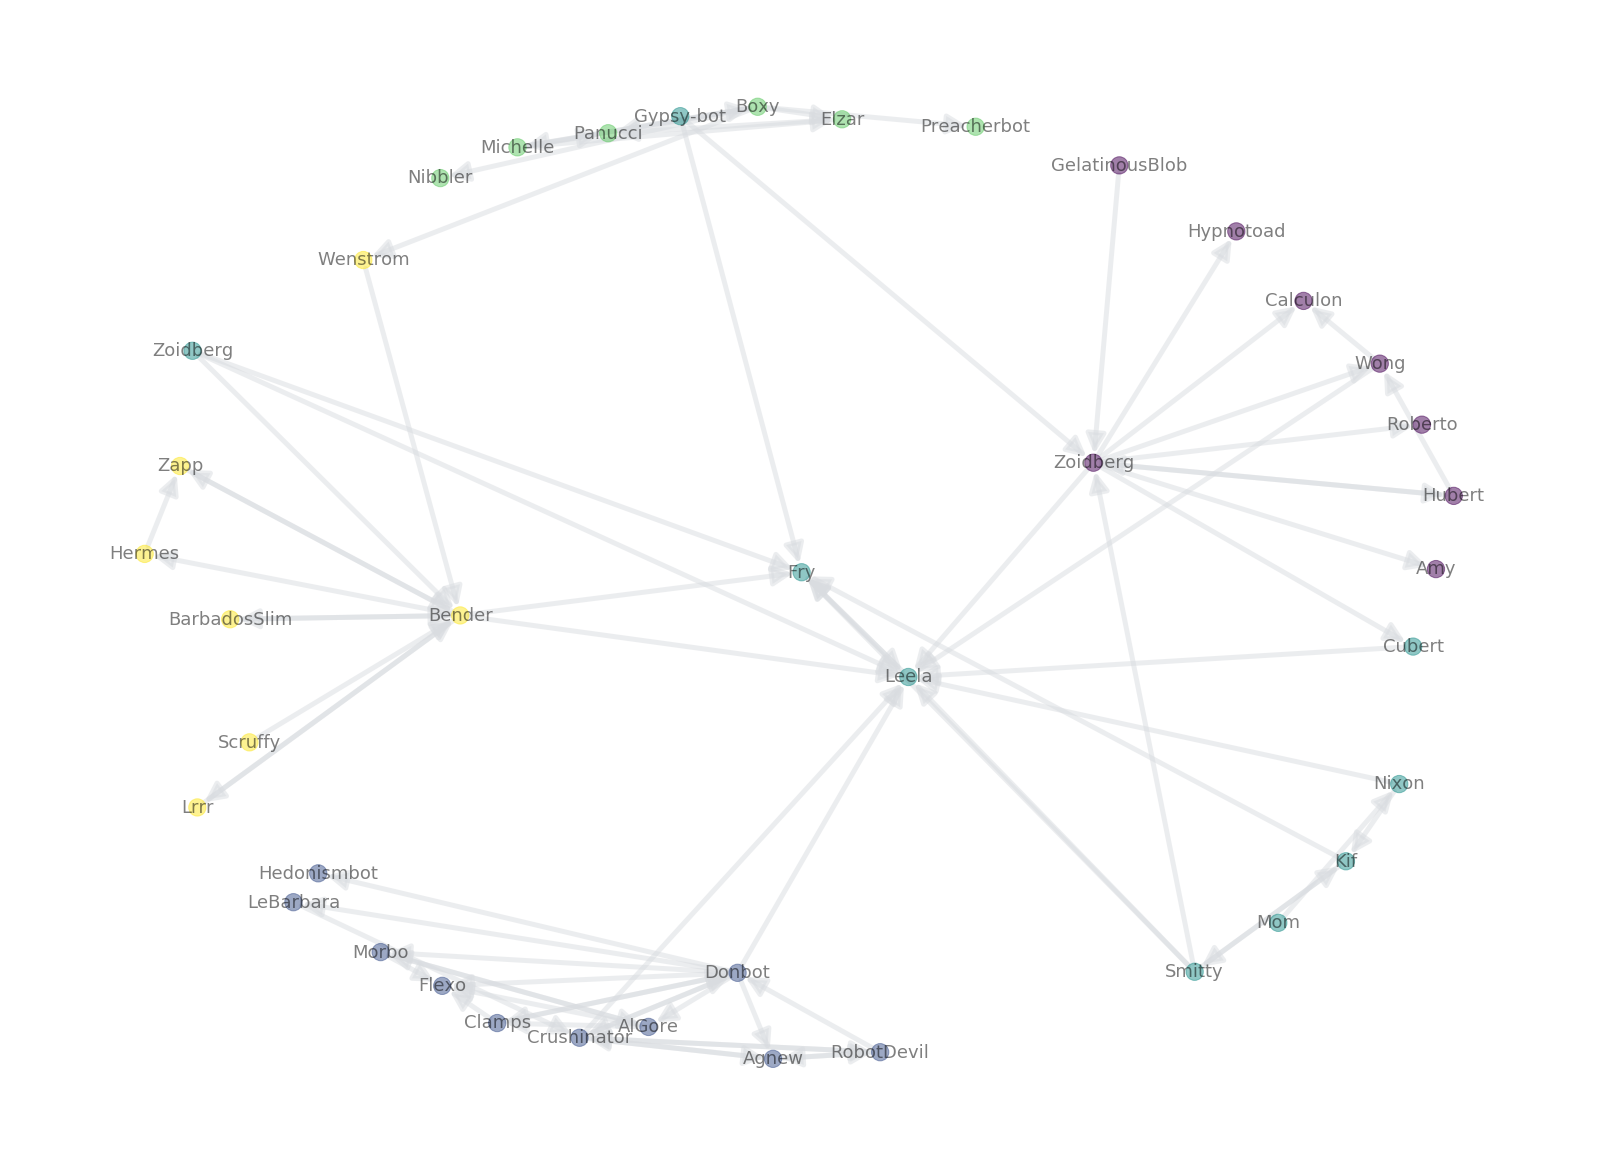

In [20]:
c_values = [communities.get(node) for node in Gsub.nodes()]

plt.figure(figsize=(22,16))

nx.draw(Gsub, 
        edge_color='#d9dce0', 
        font_size=18, 
        pos=pos,
        node_color=c_values,
        alpha=.5,
        width=5,
        arrowsize=40,
        labels=node_lables,
        with_labels=True)

## Ranking our Nodes

There are many ways to rank and 'score' nodes. <br>
There is no one right way - depends on context and goal.<br>

Some ways include:

#### Naïve:
* **Degree Centrality**: The degree centrality for a node is the fraction of other nodes in the graph it is connected to.
* **In/Out Degree Centrality**: similarly, when considering incoming/outgoing links.

#### A little more complex:
Not all nodes are created equal!
+ **Betweeness Centrality**
+ **PageRank**
+ **(HITS)**

#### Betweeness Centrality

One of the most common and important centrality measures for nodes, and for good reason.

> Betweenness centrality of a node v is the sum of the fraction of all-pairs shortest paths that pass through v. 

[(docs)](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html#networkx.algorithms.centrality.betweenness_centrality)

That's a lot to take in, and I spared you the mathematical formulation.


Intuitivly:

+ We saw that a 'path' is edge(s) that connect a given node to another given node (without repetition)
+ Shortest path between two nodes is the 'cheapest' way to get from one node to the other (the way with least edges, or for weighted graphs - lowest sum of weights).
+ Central nodes in a network have more shortest paths go through them then other nodes.



For large graphs we can approximate the BC.

In [21]:
bc = nx.centrality.betweenness.betweenness_centrality(Gsub)

bc

{88747525: 0.0,
 63721855: 0.009446693657219972,
 144630663: 0.0,
 178226065: 0.0,
 172578712: 0.0,
 113089048: 0.0,
 171734174: 0.016531713900134953,
 87972129: 0.0,
 39964577: 0.0,
 133914532: 0.002361673414304993,
 132641831: 0.0,
 200345769: 0.0033738191632928472,
 93085738: 0.012483130904183536,
 34949035: 0.0,
 164939951: 0.0,
 139862068: 0.010796221322537112,
 78935231: 0.01282051282051282,
 156165568: 0.006072874493927126,
 82053696: 0.0,
 143529671: 0.008097165991902834,
 129704264: 0.0,
 109200971: 0.0,
 56716492: 0.03171390013495277,
 148311246: 0.0,
 89357141: 0.03171390013495277,
 54646997: 0.009446693657219972,
 170878296: 0.0,
 162538841: 0.0,
 136860636: 0.0,
 180629853: 0.0,
 157137118: 0.0067476383265856945,
 117152739: 0.033738191632928474,
 70296805: 0.0006747638326585695,
 25648751: 0.0,
 152546927: 0.0,
 50857457: 0.0,
 135317744: 0.0010121457489878543,
 135319667: 0.0,
 68738163: 0.0,
 131678335: 0.001349527665317139}

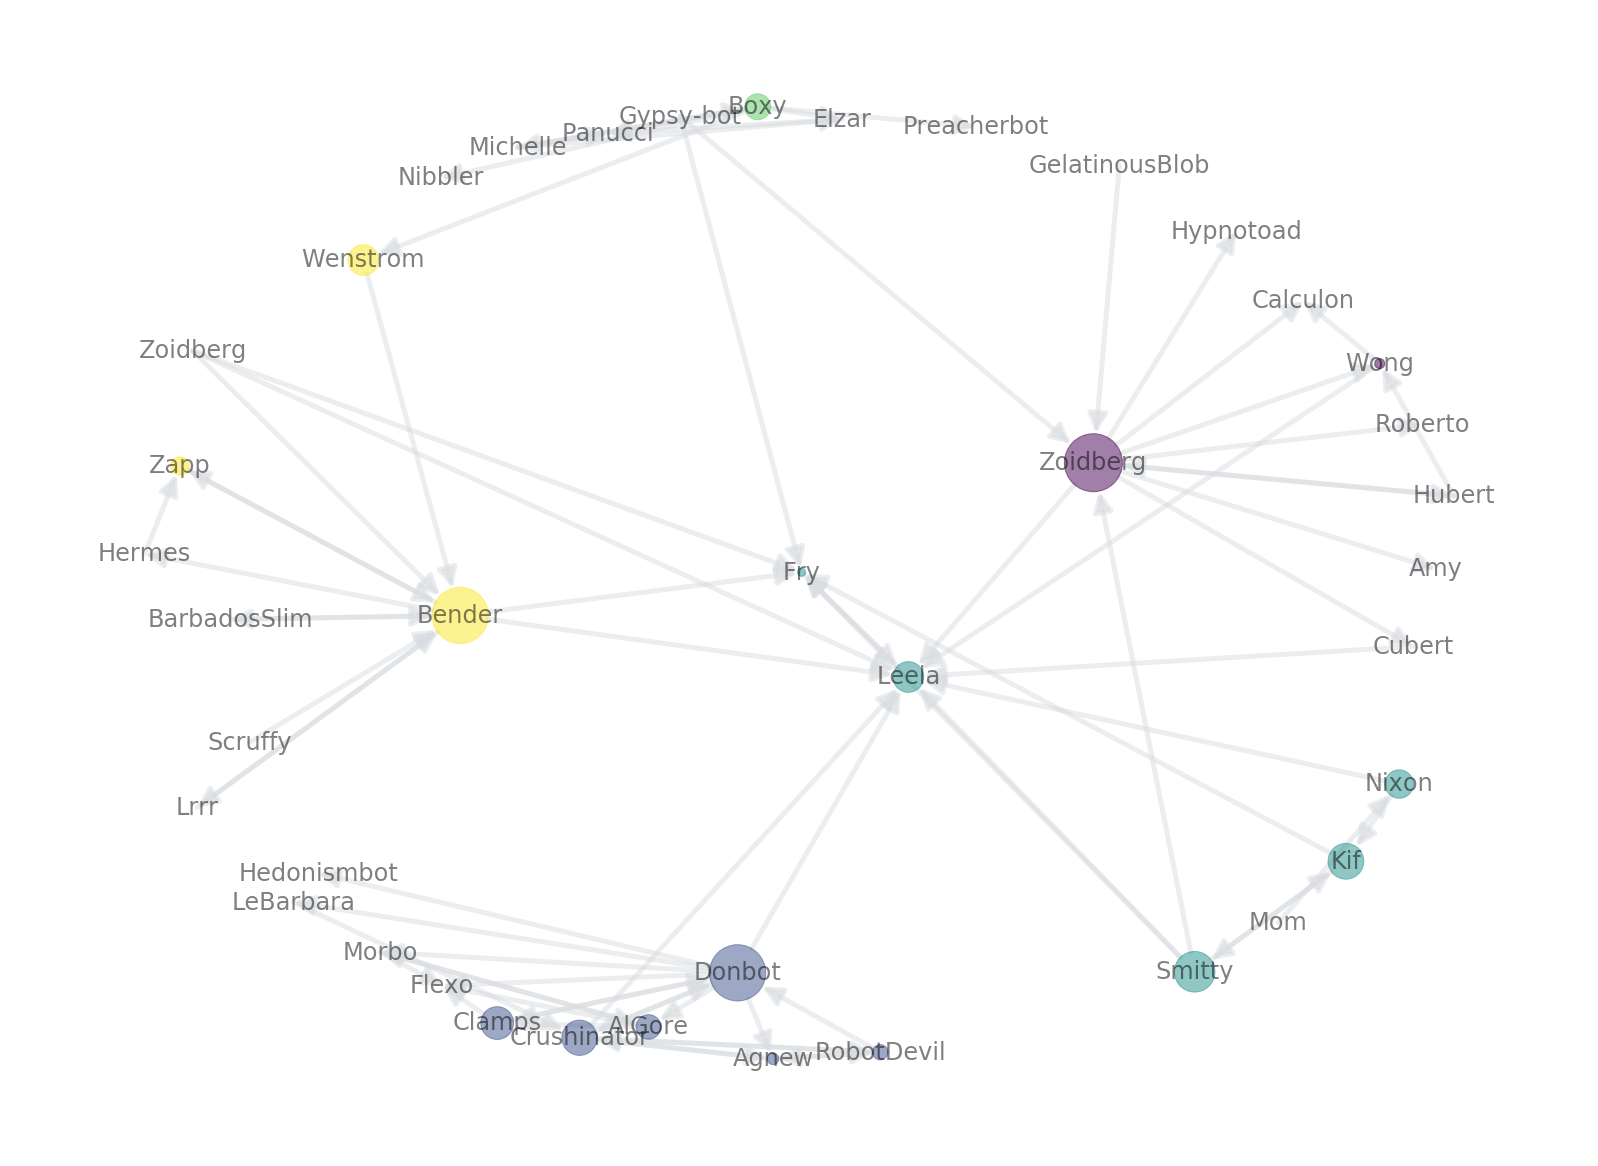

In [22]:
plt.figure(figsize=(22,16))

nx.draw(Gsub, 
        edge_color='#d9dce0', 
        font_size=24, 
        pos=pos,
        node_color=c_values,
        alpha=.5,
        width=5,
        arrowsize = 40,
        labels=node_lables,
        with_labels=True,
        node_size=[100000*bc[n] for n in Gsub.nodes()])   # <=== so easy!

### PageRank

> PageRank works by counting the **number** and **quality** of links to a page to determine a rough estimate of how important the website is. <br>The underlying assumption is that more important websites are likely to receive more links from other websites.

(Source: [wikipedia](https://en.wikipedia.org/wiki/PageRank)).

In [23]:
pr = nx.pagerank(Gsub)

pr

{88747525: 0.007765041620791972,
 63721855: 0.2482748727828941,
 144630663: 0.007765041620791972,
 178226065: 0.0057682510274736,
 172578712: 0.006860806611589982,
 113089048: 0.0057682510274736,
 171734174: 0.011154673548052286,
 87972129: 0.012467753201747027,
 39964577: 0.007765041620791972,
 133914532: 0.020266026475773177,
 132641831: 0.0057682510274736,
 200345769: 0.028757055963168215,
 93085738: 0.02873776259936353,
 34949035: 0.015544288049684706,
 164939951: 0.02130868585880963,
 139862068: 0.011518189668991846,
 78935231: 0.012673917418194418,
 156165568: 0.01278968140456339,
 82053696: 0.007765041620791972,
 143529671: 0.01067126931719339,
 129704264: 0.015544288049684706,
 109200971: 0.007894433309654501,
 56716492: 0.06900659968094996,
 148311246: 0.0057682510274736,
 89357141: 0.02251238759150785,
 54646997: 0.006860806611589982,
 170878296: 0.016288711136853984,
 162538841: 0.006860806611589982,
 136860636: 0.0057682510274736,
 180629853: 0.015544288049684706,
 15713711

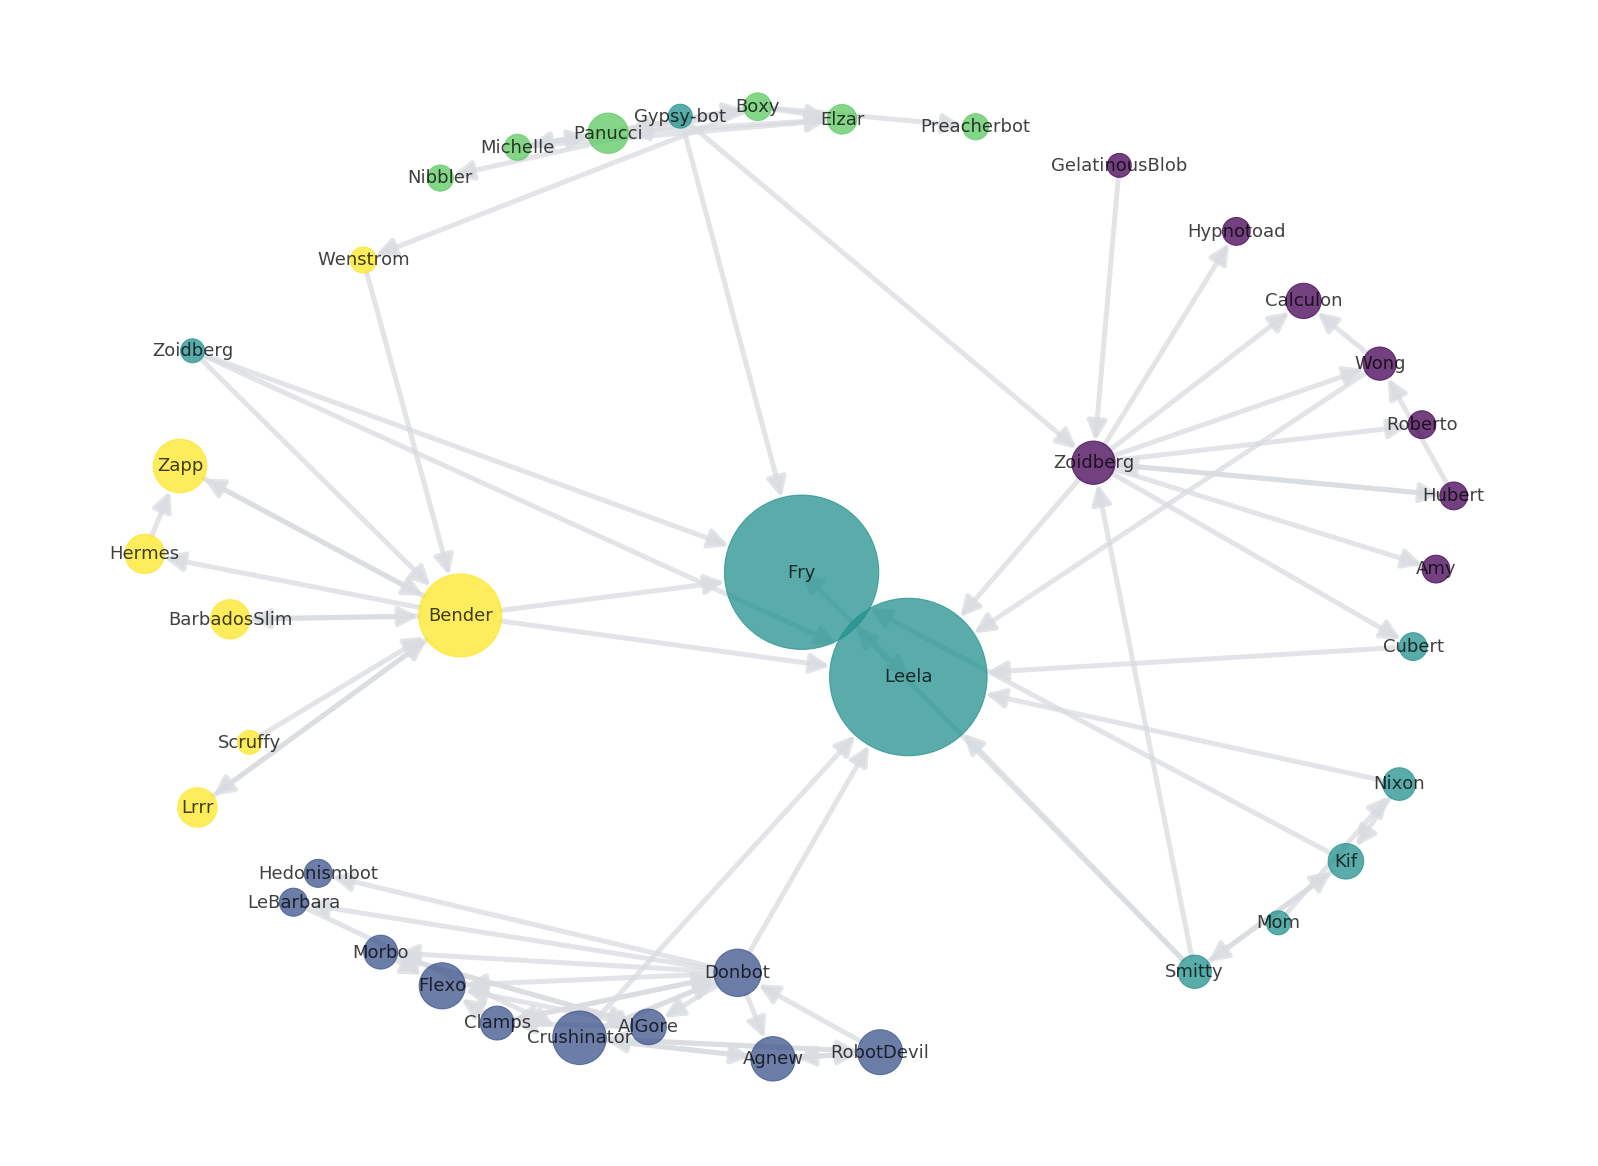

In [24]:
plt.figure(figsize=(22,16))

nx.draw(Gsub, 
        edge_color='#d9dce0', 
        font_size=18, 
        pos=pos,
        node_color=c_values,
        alpha=.75,
        width=5,
        arrowsize = 40,
        labels=node_lables,
        with_labels=True,
        node_size=[100000*pr[n] for n in Gsub.nodes()])

We see that nodes (e.g. Brandon and Todd) can be more/less important under different measures.

If we go back to our previous questions from the different teams, we can see network analysis has provided insight.

* Customer service team: who’s customer service call should we answer first?


* Marketing team: who should we spend our “influencers” marketing budget on?


* Product team: who should we recruit as a beta tester? Who are our power users?


* Customer research team: who should we interview?


### 🔙 Head back to the deck!

#### HITS - Hubs and Authorities

In [ ]:
# The HITS algorithm computes two numbers for a node.
# Authorities estimates the node value based on the incoming links.
# Hubs estimates the node value based on outgoing links.

hits = nx.hits(Gsub)  # returns (hubs, authorities)



In [ ]:
# Draw the graph according to Hubs - 
# Hubs estimates the node value based on outgoing links
# That is - nodes that send a lot of payments would be more prominent

plt.figure(figsize=(22,16))

nx.draw(Gsub, 
        edge_color='#d9dce0', 
        font_size=24,
        pos=pos,
        node_color=c_values,
        alpha=.5,
        width=5,
        arrowsize = 40,
        labels=node_lables,
        with_labels=True,
        node_size=[100000*hits[0][n] for n in Gsub.nodes()])

In [ ]:
# Similarly with Authorities - 
# Authorities estimates the node value based on the incoming links
# That is - nodes that receive a lot of payments would be more prominent

plt.figure(figsize=(22,16))

nx.draw(Gsub, 
        edge_color='#d9dce0', 
        font_size=18, 
        pos=pos,
        node_color=c_values,
        alpha=.5,
        width=5,
        arrowsize = 40,
        labels=node_lables,
        with_labels=True,
        node_size=[100000*hits[1][n] for n in Gsub.nodes()])  # reminder: The HITS algorithm returns a tuple of (hubs, authorities)

See the differences in node sizes for hubs (outgoing links) and authorities (incoming).

## Hit the deck -->

-----
# Backup

In [ ]:
from numpy import array

pos = {25648751: array([ 0.97298291,  0.59129412]),
 34949035: array([ 0.06354039,  0.46169389]),
 39964577: array([ 0.94279066,  0.43301245]),
 50857457: array([ 0.12899911,  0.19483998]),
 54646997: array([ 0.16250864,  0.8390073]),
 56716492: array([ 0.23453152,  0.465721  ]),
 63721855: array([ 0.56761181,  0.40107427]),
 68738163: array([ 0.61763327,  0.97902158]),
 70296805: array([ 0.4882674 ,  0.51108586]),
 78935231: array([ 0.89284805,  0.20748951]),
 82053696: array([ 0.81138028,  0.8690993 ]),
 87972129: array([ 0.86134286,  0.79609087]),
 88747525: array([ 0.95977045,  0.51439668]),
 89357141: array([ 0.44068317,  0.09033936]),
 93085738: array([ 0.32320231,  0.02215415]),
 109200971: array([ 0.11057107,  0.16450717]),
 113089048: array([ 0.07790915,  0.3324183]),
 117152739: array([ 0.70516503,  0.62612612]),
 129704264: array([ 0.03915662,  0.26405161]),
 131678335: array([ 0.46701907,  0.        ]),
 132641831: array([ 0.72441621,  0.9384347 ]),
 133914532: array([ 0.54667241,  0.00696261]),
 135317744: array([ 0.91799674,  0.73020564]),
 135319667: array([ 0.1754183 ,  0.11210485]),
 136860636: array([ 0.3981246 ,  0.99010875]),
 139862068: array([ 0.26202507,  0.03757688]),
 143529671: array([ 0.9324676 ,  0.28861159]),
 144630663: array([ 0.94929298,  0.66610523]),
 148311246: array([ 0.84256375,  0.14285106]),
 152546927: array([ 0.5183958 ,  0.98684109]),
 156165568: array([ 0.37448625,  0.03352678]),
 157137118: array([ 0.45562268,  1.        ]),
 162538841: array([ 0.27709792,  0.95739592]),
 164939951: array([ 0.22118716,  0.07667276]),
 170878296: array([ 0.34450476,  0.97220142]),
 171734174: array([ 0.78041241,  0.09146471]),
 172578712: array([ 0.21977031,  0.92508207]),
 178226065: array([ 0.03560208,  0.74368425]),
 180629853: array([ 0.        ,  0.53035337]),
 200345769: array([ 0.02626842,  0.62267393])}

### Housekeeping

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade networkx

In [ ]:
import platform
print(platform.python_version())

In [ ]:
# CC - a simple example


Gcc = nx.Graph([('John', 'Stacey'), ('Stacey', 'Becky'), ('John', 'Jane'), ('Jane', 'Stacey'),
               
               ('Dan', 'Donna'), ('Donna', 'Martha'), ('Dan', 'Martha')])

plt.figure(figsize=(12,8), frameon=False)

nx.draw(Gcc, 
        with_labels=True,
        node_size=5000,                 # just so it's easier to read
        font_size=16,
        font_weight='bold',
        node_color='g', alpha=.5,
        pos=nx.spring_layout(Gcc, k=1))